In [42]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from PIL import Image
from pathlib import Path
from IPython.display import clear_output

ROOT_DIR = Path('/home/batman/.cache/huggingface/hub/models--stabilityai--stable-diffusion-3-medium-diffusers/snapshots/ea42f8cef0f178587cf766dc8129abd379c90671')

default_sample_size = 128
vae_scale_factor = 8
height = width = default_sample_size * vae_scale_factor
batch_size = 1
num_images_per_prompt = 1
max_sequence_length = 256
num_inference_steps = 28
guidance_scale = 7.0
device = torch.device('cuda:0')
dtype = torch.float16
# device = torch.device('cpu')
# dtype = torch.float32

prompt = "A man in a space suit on the Paris metro at rush hour, waiting to get off at his stop."

clear_output()

In [7]:
from tokenizer.clip import CLIPTokenizer
from models.clip import CLIPTextModelWithProjection

tokenizer = CLIPTokenizer.from_pretrained(ROOT_DIR / 'tokenizer')
text_encoder = CLIPTextModelWithProjection.from_pretrained(ROOT_DIR / 'text_encoder').to(device=device, dtype=dtype)

tokenizer_2 = CLIPTokenizer.from_pretrained(ROOT_DIR / 'tokenizer_2')
text_encoder_2 = CLIPTextModelWithProjection.from_pretrained(ROOT_DIR / 'text_encoder_2').to(device=device, dtype=dtype)

def get_clip_prompt_embeds(prompt, second=False):
    _tokenizer = tokenizer_2 if second else tokenizer
    _text_encoder = text_encoder_2 if second else text_encoder

    text_input_ids = _tokenizer(prompt, max_length=77)
    prompt_embeds = _text_encoder(torch.as_tensor(text_input_ids).to(device))
    pooled_prompt_embeds = prompt_embeds.text_embeds
    prompt_embeds = prompt_embeds.hidden_states[-2]
    prompt_embeds = prompt_embeds.to(dtype=dtype, device=device)

    _, seq_len, _ = prompt_embeds.shape
    prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
    prompt_embeds = prompt_embeds.view(batch_size * num_images_per_prompt, seq_len, -1)

    pooled_prompt_embeds = pooled_prompt_embeds.repeat(1, num_images_per_prompt, 1)
    pooled_prompt_embeds = pooled_prompt_embeds.view(batch_size * num_images_per_prompt, -1)
    return prompt_embeds, pooled_prompt_embeds

clear_output()

In [2]:
from tokenizer.t5 import T5Tokenizer
from models.t5 import T5EncoderModel

tokenizer_3 = T5Tokenizer.from_pretrained(ROOT_DIR / 'tokenizer_3')
text_encoder_3 = T5EncoderModel.from_pretrained(ROOT_DIR / 'text_encoder_3').to(device=device, dtype=dtype)

def get_t5_prompt_embeds(prompt):
    text_inputs = tokenizer_3(prompt, max_length=256)
    prompt_embeds = text_encoder_3(torch.as_tensor(text_inputs).to(device))
    prompt_embeds = prompt_embeds.to(dtype=dtype, device=device)
    _, seq_len, _ = prompt_embeds.shape

    # duplicate text embeddings and attention mask for each generation per prompt, using mps friendly method
    prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
    prompt_embeds = prompt_embeds.view(batch_size * num_images_per_prompt, seq_len, -1)

    return prompt_embeds

clear_output()

In [26]:
from scheduler import FlowMatchEulerDiscreteScheduler
scheduler = FlowMatchEulerDiscreteScheduler.from_pretrained(ROOT_DIR / 'scheduler')

In [4]:
from models.sd3 import SD3Transformer2DModel
transformer = SD3Transformer2DModel.from_pretrained(ROOT_DIR / 'transformer').to(dtype=dtype, device=device)
num_channels_latents = transformer.config.in_channels
clear_output()

In [5]:
from models.vae import AutoencoderKL
vae = AutoencoderKL.from_pretrained(ROOT_DIR / 'vae').to(dtype=dtype, device=device)
clear_output()

100%|██████████| 28/28 [00:02<00:00,  9.73it/s]


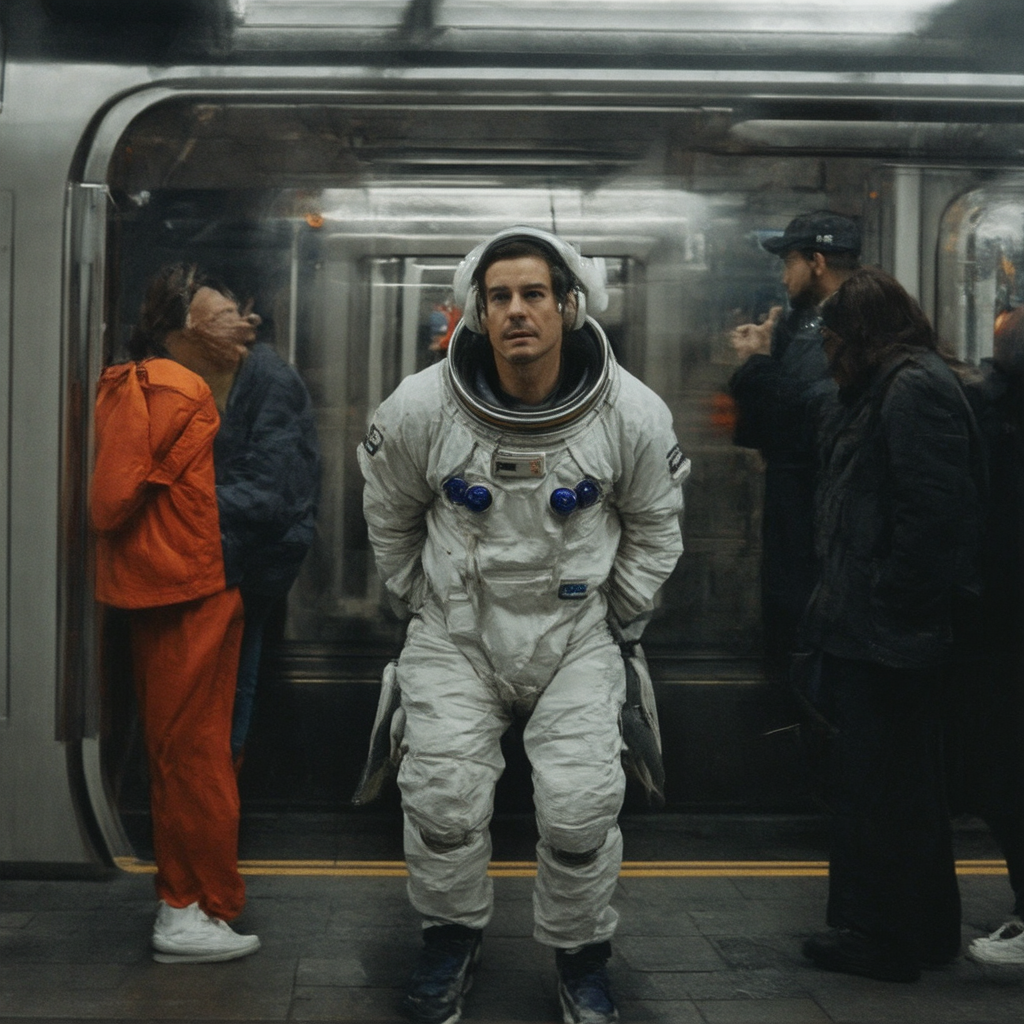

In [47]:
def get_prompt_embeds(prompt, negative_prompt=""):
    prompt_embed, pooled_prompt_embed = get_clip_prompt_embeds(prompt)
    prompt_2_embed, pooled_prompt_2_embed = get_clip_prompt_embeds(prompt, second=True)
    clip_prompt_embeds = torch.cat([prompt_embed, prompt_2_embed], dim=-1)

    t5_prompt_embed = get_t5_prompt_embeds(prompt)
    clip_prompt_embeds = F.pad(clip_prompt_embeds, (0, t5_prompt_embed.shape[-1] - clip_prompt_embeds.shape[-1]))
    prompt_embeds = torch.cat([clip_prompt_embeds, t5_prompt_embed], dim=-2)
    pooled_prompt_embeds = torch.cat([pooled_prompt_embed, pooled_prompt_2_embed], dim=-1)

    negative_prompt_embed, negative_pooled_prompt_embed = get_clip_prompt_embeds(negative_prompt)
    negative_prompt_2_embed, negative_pooled_prompt_2_embed = get_clip_prompt_embeds(negative_prompt, second=True)
    negative_clip_prompt_embeds = torch.cat([negative_prompt_embed, negative_prompt_2_embed], dim=-1)

    t5_negative_prompt_embed = get_t5_prompt_embeds(negative_prompt)
    negative_clip_prompt_embeds = F.pad(negative_clip_prompt_embeds, (0, t5_negative_prompt_embed.shape[-1] - negative_clip_prompt_embeds.shape[-1]))
    negative_prompt_embeds = torch.cat([negative_clip_prompt_embeds, t5_negative_prompt_embed], dim=-2)
    negative_pooled_prompt_embeds = torch.cat([negative_pooled_prompt_embed, negative_pooled_prompt_2_embed], dim=-1)

    combined_prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds], dim=0)
    combined_pooled_prompt_embeds = torch.cat([negative_pooled_prompt_embeds, pooled_prompt_embeds], dim=0)
    return combined_prompt_embeds, combined_pooled_prompt_embeds

@torch.no_grad()
def sample(prompt, num_inference_steps=28, guidance_scale = 2.0):
    prompt_embeds, pooled_prompt_embeds = get_prompt_embeds(prompt)

    shape = (batch_size, num_channels_latents, int(height) // vae_scale_factor, int(width) // vae_scale_factor)
    latents = torch.randn(shape, device=device, dtype=dtype).to(device)
    scheduler.set_timesteps(num_inference_steps)

    for t in tqdm(scheduler.timesteps):
        latent_model_input = torch.cat([latents] * 2)
        timestep = torch.as_tensor(t).expand(latent_model_input.shape[0]).to(device)

        noise_pred = transformer(
            hidden_states=latent_model_input,
            timestep=timestep,
            encoder_hidden_states=prompt_embeds,
            pooled_projections=pooled_prompt_embeds,
        )

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents)

    latents = (latents / vae.config.scaling_factor) + vae.config.shift_factor
    images = vae.decode(latents)
    images = (images / 2 + 0.5).clamp(0, 1)
    images = images.cpu().permute(0, 2, 3, 1).numpy()
    images = (images * 255).astype(np.uint8)
    images = [Image.fromarray(image) for image in images]
    return images

image = sample(prompt, num_inference_steps=28, guidance_scale=2.0)
image[0]